# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

## 💪 Competition Challenge

1. Recommend 10 additional regions they should select for the promotion.
2. Tell the story that supports your recommendations.

# Exploratory Data Analysis

In [167]:
import pandas as pd
import numpy as np

# Missing Data Package
import missingno as msno

# Plot visualization
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import FuncFormatter

# Algorithms
from sklearn.cluster import KMeans as KNN
from scipy.stats import linregress as LinearRegression

# Customization
sns.set_style('whitegrid')

In [168]:
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df.head(10)

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2
5,1998,Republic of Bashkortostan,1.8,17.5,10.7,0.9,0.2
6,1998,Belgorod Oblast,3.4,23.0,10.8,0.9,0.1
7,1998,Bryansk Oblast,3.4,32.4,9.7,0.5,0.1
8,1998,Republic of Buryatia,1.1,8.8,15.8,0.9,0.1
9,1998,Vladimir Oblast,1.5,16.6,16.8,0.5,0.1


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


In [170]:
years = df['year'].unique()
len(years)

19

In [171]:
regions = df['region'].unique()
len(regions)

85

<AxesSubplot:>

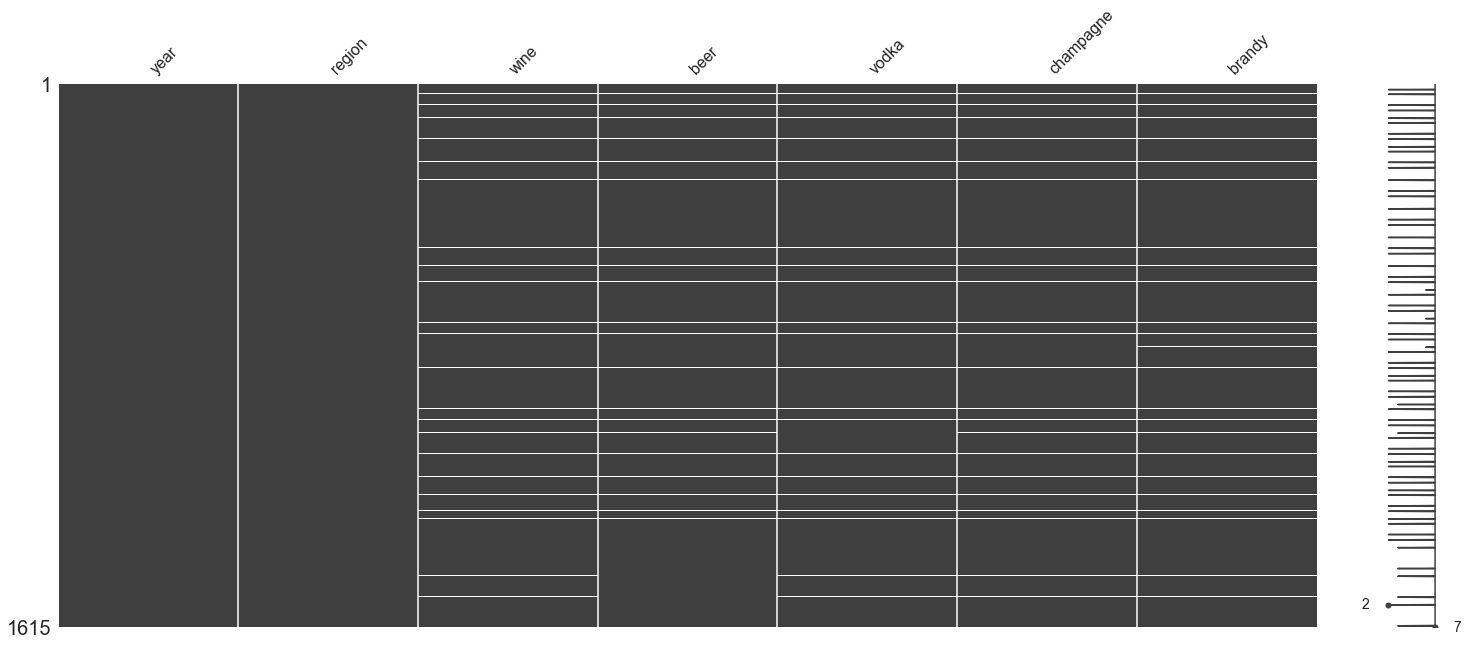

In [172]:
msno.matrix(df)

## Thoughts

So far, I can see there are 85 unique regions in Russia with data collected from 1998 to 2016. The graph above shows that some rows have no data.

year          0
region        0
wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64

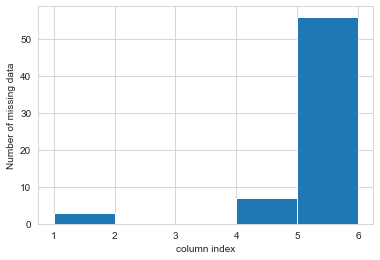

In [173]:
# Total number of missing data per row
nMissing_row = df.isna().sum(axis=1)
nMissing_row[nMissing_row > 0].hist(bins = [1,2,3,4,5,6])
plt.xlabel('column index')
plt.ylabel('Number of missing data')

# Total number of missing data per column
nMissing_col = df.isna().sum(axis=0)
nMissing_col

## Thoughts

From the information above, we have MNAR case. There are 50+ rows that do not have any data on the alcohol drinks for a given region and year. Before deleting these rows, I need to determine what regions and years the information is missing from.

In [174]:
df_missing = df.copy(deep=True)
df_missing.iloc[:,2:] = df.iloc[:,2:].isna()
df_missing

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,False,False,False,False,False
1,1998,Altai Krai,False,False,False,False,False
2,1998,Amur Oblast,False,False,False,False,False
3,1998,Arkhangelsk Oblast,False,False,False,False,False
4,1998,Astrakhan Oblast,False,False,False,False,False
...,...,...,...,...,...,...,...
1610,2016,Chuvash Republic,False,False,False,False,False
1611,2016,Chukotka Autonomous Okrug,False,False,False,False,False
1612,2016,Sakha (Yakutia) Republic,False,False,False,False,False
1613,2016,Yamalo-Nenets Autonomous Okrug,False,False,False,False,False


In [175]:
df_missing_year = df_missing.groupby('year').sum()
df_missing_year

,wine,beer,vodka,champagne,brandy
year,,,,,
1998,4,4,4,4,4
1999,4,4,4,4,4
2000,4,4,4,4,4
2001,3,3,3,3,3
2002,3,3,3,3,3
2003,3,3,3,3,3
2004,3,3,3,3,3
2005,3,3,3,3,4
2006,3,3,3,3,4


In [176]:
df_missing_region = df_missing.groupby('region').sum()
df_missing_region.drop(columns = 'year', inplace = True)

# Get Regions with missing Data
df_missing_region[ df_missing_region.sum(axis=1) > 0 ]

,wine,beer,vodka,champagne,brandy
region,,,,,
Chechen Republic,19,16,19,19,19
Republic of Crimea,16,16,16,16,16
Republic of Ingushetia,12,10,10,12,15
Sevastopol,16,16,16,16,16


In [177]:
df[ df['region'] == 'Chechen Republic']

,year,region,wine,beer,vodka,champagne,brandy
79,1998,Chechen Republic,NaN,NaN,NaN,NaN,NaN
164,1999,Chechen Republic,NaN,NaN,NaN,NaN,NaN
249,2000,Chechen Republic,NaN,NaN,NaN,NaN,NaN
334,2001,Chechen Republic,NaN,NaN,NaN,NaN,NaN
419,2002,Chechen Republic,NaN,NaN,NaN,NaN,NaN
504,2003,Chechen Republic,NaN,NaN,NaN,NaN,NaN
589,2004,Chechen Republic,NaN,NaN,NaN,NaN,NaN
674,2005,Chechen Republic,NaN,NaN,NaN,NaN,NaN
759,2006,Chechen Republic,NaN,NaN,NaN,NaN,NaN
844,2007,Chechen Republic,NaN,NaN,NaN,NaN,NaN


In [178]:
df[ df['region'] == 'Republic of Crimea']

,year,region,wine,beer,vodka,champagne,brandy
31,1998,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
116,1999,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
201,2000,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
286,2001,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
371,2002,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
456,2003,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
541,2004,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
626,2005,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
711,2006,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
796,2007,Republic of Crimea,NaN,NaN,NaN,NaN,NaN


In [179]:
df[ df['region'] == 'Republic of Ingushetia']

,year,region,wine,beer,vodka,champagne,brandy
17,1998,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
102,1999,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
187,2000,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
272,2001,Republic of Ingushetia,9.9,9.5,4.00,1.3,1.5
357,2002,Republic of Ingushetia,7.5,8.7,4.30,0.8,0.8
442,2003,Republic of Ingushetia,6.0,8.9,4.60,0.8,0.5
527,2004,Republic of Ingushetia,6.4,7.4,3.60,0.8,0.8
612,2005,Republic of Ingushetia,0.2,0.8,0.80,0.1,NaN
697,2006,Republic of Ingushetia,0.3,0.9,1.00,0.1,NaN
782,2007,Republic of Ingushetia,0.3,1.0,1.00,0.1,NaN


In [180]:
df[ df['region'] == 'Sevastopol']

,year,region,wine,beer,vodka,champagne,brandy
63,1998,Sevastopol,NaN,NaN,NaN,NaN,NaN
148,1999,Sevastopol,NaN,NaN,NaN,NaN,NaN
233,2000,Sevastopol,NaN,NaN,NaN,NaN,NaN
318,2001,Sevastopol,NaN,NaN,NaN,NaN,NaN
403,2002,Sevastopol,NaN,NaN,NaN,NaN,NaN
488,2003,Sevastopol,NaN,NaN,NaN,NaN,NaN
573,2004,Sevastopol,NaN,NaN,NaN,NaN,NaN
658,2005,Sevastopol,NaN,NaN,NaN,NaN,NaN
743,2006,Sevastopol,NaN,NaN,NaN,NaN,NaN
828,2007,Sevastopol,NaN,NaN,NaN,NaN,NaN


# Thoughts

From the information above, we can drop the following:

- Chechen Republic due to the lack of data for any alcoholic drink
- Republic of Ingushetia due to the lack of recent ( within 5 years ) of data for any alcoholic drink

I'll keep the Republic of Crimea and Sevastopol since both regions contain full data on alcoholic drinks from within the last 3 years.

In [181]:
# Drop the regions from aboce

df_V2 = df[ (df['region'] != "Chechen Republic") & (df['region'] != "Republic of Ingushetia") ]
df_V2

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2
...,...,...,...,...,...,...,...
1610,2016,Chuvash Republic,5.0,42.3,7.7,0.7,0.4
1611,2016,Chukotka Autonomous Okrug,3.9,34.0,11.6,1.8,1.1
1612,2016,Sakha (Yakutia) Republic,4.3,56.1,8.2,1.8,0.5
1613,2016,Yamalo-Nenets Autonomous Okrug,4.5,75.8,8.2,1.7,1.3


# Thoughts

I am interested to know the dominance of wine compare to the other drinks. I can add the columns of each row to determine the total number of litres sales per year per capita and find the percentage of wine liter sales.

In [182]:
df[ df['region'] == 'Saint Petersburg']

,year,region,wine,beer,vodka,champagne,brandy
59,1998,Saint Petersburg,2.7,27.90,12.30,1.20,0.50
144,1999,Saint Petersburg,2.6,57.40,13.00,1.70,0.60
229,2000,Saint Petersburg,4.4,68.20,14.70,2.00,0.90
314,2001,Saint Petersburg,6.2,101.00,15.50,2.40,0.80
399,2002,Saint Petersburg,6.3,104.60,17.20,2.60,0.90
484,2003,Saint Petersburg,6.6,105.60,14.30,2.80,1.00
569,2004,Saint Petersburg,4.7,103.90,13.90,2.50,0.80
654,2005,Saint Petersburg,10.3,104.80,16.20,2.40,1.10
739,2006,Saint Petersburg,7.6,125.30,16.40,2.40,1.40
824,2007,Saint Petersburg,9.1,106.40,14.00,2.70,1.40


In [183]:
df_V2['Total Sales'] = df_V2.loc[:,'wine':'brandy'].sum(axis = 1)

df_V2.loc[:,'wine':'brandy'] = df_V2.loc[:,'wine':'brandy'].apply( lambda x: (x/ df_V2['Total Sales']) * 100 ) 

df_SaintPeterburg = df_V2[ df_V2['region'] == 'Saint Petersburg']

df_SaintPeterburg

/var/folders/_6/jplnpf590f180r_srq2j11zm0000gn/T/ipykernel_11125/1744422002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V2['Total Sales'] = df_V2.loc[:,'wine':'brandy'].sum(axis = 1)
/Users/father/opt/anaconda3/envs/minimal_ds/lib/python3.9/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,year,region,wine,beer,vodka,champagne,brandy,Total Sales
59,1998,Saint Petersburg,6.053812,62.556054,27.578475,2.690583,1.121076,44.60
144,1999,Saint Petersburg,3.452855,76.228420,17.264276,2.257636,0.796813,75.30
229,2000,Saint Petersburg,4.878049,75.609756,16.297118,2.217295,0.997783,90.20
314,2001,Saint Petersburg,4.924543,80.222399,12.311358,1.906275,0.635425,125.90
399,2002,Saint Petersburg,4.787234,79.483283,13.069909,1.975684,0.683891,131.60
484,2003,Saint Petersburg,5.065234,81.043745,10.974674,2.148887,0.767460,130.30
569,2004,Saint Petersburg,3.736089,82.591415,11.049285,1.987281,0.635930,125.80
654,2005,Saint Petersburg,7.640950,77.744807,12.017804,1.780415,0.816024,134.80
739,2006,Saint Petersburg,4.964076,81.841933,10.711953,1.567603,0.914435,153.10
824,2007,Saint Petersburg,6.811377,79.640719,10.479042,2.020958,1.047904,133.60


Text(0.5, 0, 'Year')

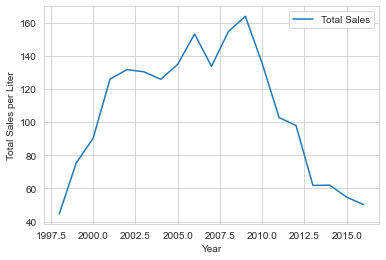

In [184]:
df_SaintPeterburg.plot(x='year',y='Total Sales')
plt.ylabel('Total Sales per Liter')
plt.xlabel('Year')

In [185]:
df_SaintPeterburg_melted = df_SaintPeterburg.melt(id_vars=['year','region','Total Sales'], value_vars = ['wine','beer','vodka','champagne','brandy'],var_name='Type',value_name='Sale Percentage')
df_SaintPeterburg_melted

,year,region,Total Sales,Type,Sale Percentage
0,1998,Saint Petersburg,44.6,wine,6.053812
1,1999,Saint Petersburg,75.3,wine,3.452855
2,2000,Saint Petersburg,90.2,wine,4.878049
3,2001,Saint Petersburg,125.9,wine,4.924543
4,2002,Saint Petersburg,131.6,wine,4.787234
...,...,...,...,...,...
90,2012,Saint Petersburg,97.9,brandy,1.327886
91,2013,Saint Petersburg,61.8,brandy,1.618123
92,2014,Saint Petersburg,61.9,brandy,2.100162
93,2015,Saint Petersburg,54.7,brandy,2.376600


(1998.0, 2016.0)

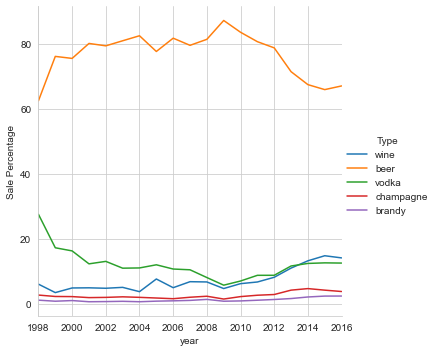

In [186]:
sns.relplot(x='year',y='Sale Percentage',data = df_SaintPeterburg_melted , hue = 'Type',kind ='line')
plt.xlim([1998,2016])


# Thoughts

There is a steep increase in alcohol sales per liter from 1998 to 2009, with beer having an 80% dominance of the total sales per liter per capital. However, in 2009, the sales of alcohol began to drop steadily. Beer lost a portion of it's domiance and the other drinks began to increase in sales. By 2016, wine was the second most sold drink in Saint Peterburg with a 14.1% dominance in total sales per liter per capital.

# Where to go from here

Given the inflection point in 2009, it would be ideal that we find regions that follow Saint Peterburgs trend on decreasing the sales of beer and increasing the sales of the other drinks. Thus, we'll only observe the years from 2009 to 2016. In addition, we'll use K-Mean algorithm to find the regions closely related to Saint Peterburg. 

In [187]:
df_V3 = df_V2[ df_V2['year'] >= 2009 ]
df_V3.fillna(value = -1,inplace = True)

df_V3

/Users/father/opt/anaconda3/envs/minimal_ds/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,year,region,wine,beer,vodka,champagne,brandy,Total Sales
935,2009,Republic of Adygea,14.020619,64.948454,15.257732,3.298969,2.474227,48.5
936,2009,Altai Krai,5.792683,78.658537,12.957317,2.134146,0.457317,65.6
937,2009,Amur Oblast,7.309322,79.766949,11.122881,1.271186,0.529661,94.4
938,2009,Arkhangelsk Oblast,16.353111,56.005789,23.010130,3.039074,1.591896,69.1
939,2009,Astrakhan Oblast,6.562848,82.313682,9.677419,1.001112,0.444939,89.9
...,...,...,...,...,...,...,...,...
1610,2016,Chuvash Republic,8.912656,75.401070,13.725490,1.247772,0.713012,56.1
1611,2016,Chukotka Autonomous Okrug,7.442748,64.885496,22.137405,3.435115,2.099237,52.4
1612,2016,Sakha (Yakutia) Republic,6.064880,79.125529,11.565585,2.538787,0.705219,70.9
1613,2016,Yamalo-Nenets Autonomous Okrug,4.918033,82.841530,8.961749,1.857923,1.420765,91.5


In [188]:
df_V3_melted = pd.melt(df_V3,id_vars=['year','region','Total Sales'], value_vars = ['wine','beer','vodka','champagne','brandy'],var_name='Type',value_name='Sale Percentage')
df_V3_melted

,year,region,Total Sales,Type,Sale Percentage
0,2009,Republic of Adygea,48.5,wine,14.020619
1,2009,Altai Krai,65.6,wine,5.792683
2,2009,Amur Oblast,94.4,wine,7.309322
3,2009,Arkhangelsk Oblast,69.1,wine,16.353111
4,2009,Astrakhan Oblast,89.9,wine,6.562848
...,...,...,...,...,...
3315,2016,Chuvash Republic,56.1,brandy,0.713012
3316,2016,Chukotka Autonomous Okrug,52.4,brandy,2.099237
3317,2016,Sakha (Yakutia) Republic,70.9,brandy,0.705219
3318,2016,Yamalo-Nenets Autonomous Okrug,91.5,brandy,1.420765


In [189]:
df_V3_melted['Type_Year']=df_V3_melted['Type'] + "_"+ df_V3_melted['year'].apply(lambda x:str(x))
df_V3_melted_V2 = df_V3_melted.drop(columns=['year','Type'])
df_V3_melted_V2

,region,Total Sales,Sale Percentage,Type_Year
0,Republic of Adygea,48.5,14.020619,wine_2009
1,Altai Krai,65.6,5.792683,wine_2009
2,Amur Oblast,94.4,7.309322,wine_2009
3,Arkhangelsk Oblast,69.1,16.353111,wine_2009
4,Astrakhan Oblast,89.9,6.562848,wine_2009
...,...,...,...,...
3315,Chuvash Republic,56.1,0.713012,brandy_2016
3316,Chukotka Autonomous Okrug,52.4,2.099237,brandy_2016
3317,Sakha (Yakutia) Republic,70.9,0.705219,brandy_2016
3318,Yamalo-Nenets Autonomous Okrug,91.5,1.420765,brandy_2016


In [190]:
df_V3_melted_V4 = df_V3_melted_V2.pivot_table(index='region',columns=['Type_Year'],values=['Total Sales','Sale Percentage']).reset_index()
df_V3_melted_V4

region Sale Percentage             \
Type_Year                                       beer_2009  beer_2010   
0                              Altai Krai       78.658537  78.877005   
1                          Altai Republic       78.020566  77.390181   
2                             Amur Oblast       79.766949  77.983539   
3                      Arkhangelsk Oblast       56.005789  55.678670   
4                        Astrakhan Oblast       82.313682  82.108626   
..                                    ...             ...        ...   
78                         Vologda Oblast       73.931997  78.591034   
79                        Voronezh Oblast       76.659751  79.510022   
80         Yamalo-Nenets Autonomous Okrug       78.727273  78.597122   
81                       Yaroslavl Oblast       73.408624  74.294060   
82                       Zabaykalsky Krai       75.480226  75.491329   

                                                                             \
Type_Year  beer_2011  beer_2012  beer_2013  beer_2014  beer_2015  beer_2016   
0          78.657402  79.909194  81.257862  82.807571  81.932021  78.361345   
1          77.897913  79.119497  80.188679  72.490706  75.186567  77.289377   
2          79.274562  77.823409  79.386892  79.207921  77.522936  77.011494   
3          55.989233  64.566929  64.566929  70.847085  67.630854  68.891856   
4          83.524946  83.281087  85.791757  83.311258  77.432712  78.483607   
..               ...        ...        ...        ...        ...        ...   
78         76.222756  80.206795  79.930495  73.556582  64.022140  64.756944   
79         82.849253  81.746811  82.718447  83.203125  81.629393  78.765880   
80         80.331131  80.176565  81.146179  82.173499  83.451060  82.841530   
81         75.828919  74.291498  78.748759  73.285199  65.767285  63.865546   
82         75.360848  75.808250  75.793184  69.285714  68.308351  68.141593   

                       ... Total Sales                                 \
Type_Year brandy_2009  ...  vodka_2015 vodka_2016 wine_2009 wine_2010   
0            0.457317  ...        55.9       47.6      65.6      74.8   
1            0.514139  ...        53.6       54.6      77.8      77.4   
2            0.529661  ...        65.4       60.9      94.4      97.2   
3            1.591896  ...        72.6       74.9      69.1      72.2   
4            0.444939  ...        48.3       48.8      89.9      93.9   
..                ...  ...         ...        ...       ...       ...   
78           0.435920  ...        54.2       57.6     114.7     109.3   
79           0.622407  ...        62.6       55.1      96.4      89.8   
80           1.181818  ...        99.1       91.5     110.0     111.2   
81           0.718686  ...        59.3       59.5      97.4     102.7   
82           0.451977  ...        46.7       45.2      88.5      86.5   

                                                                       
Type_Year wine_2011 wine_2012 wine_2013 wine_2014 wine_2015 wine_2016  
0             80.59      88.1      79.5      63.4      55.9      47.6  
1             79.54      79.5      74.2      53.8      53.6      54.6  
2            105.04      97.4      94.6      80.8      65.4      60.9  
3             74.30      76.2      76.2      90.9      72.6      74.9  
4             92.20      95.7      92.2      75.5      48.3      48.8  
..              ...       ...       ...       ...       ...       ...  
78           116.54     135.4     115.1      86.6      54.2      57.6  
79            97.78     101.9     103.0      76.8      62.6      55.1  
80           125.63     124.6     120.4     104.9      99.1      91.5  
81           101.94      98.8     100.7      83.1      59.3      59.5  
82            88.68      89.7      85.1      56.0      46.7      45.2  

[83 rows x 81 columns]

In [191]:
#columns.droplevel(0)

df_V3_melted_V4[df_V3_melted_V4['region'] =='Altai Krai']

region Sale Percentage                                   \
Type_Year                   beer_2009  beer_2010  beer_2011  beer_2012   
0          Altai Krai       78.658537  78.877005  78.657402  79.909194   

                                                                   ...  \
Type_Year  beer_2013  beer_2014  beer_2015  beer_2016 brandy_2009  ...   
0          81.257862  82.807571  81.932021  78.361345    0.457317  ...   

          Total Sales                                                     \
Type_Year  vodka_2015 vodka_2016 wine_2009 wine_2010 wine_2011 wine_2012   
0                55.9       47.6      65.6      74.8     80.59      88.1   

                                                   
Type_Year wine_2013 wine_2014 wine_2015 wine_2016  
0              79.5      63.4      55.9      47.6  

[1 rows x 81 columns]

In [192]:
x = df_V3_melted_V4.iloc[:,1:]
y = df_V3_melted_V4.iloc[:,0]

KNN_classifier = KNN(n_clusters=5)

KNN_classifier.fit(x,y)

df_V3_melted_V4['Cluster'] = KNN_classifier.labels_

/Users/father/opt/anaconda3/envs/minimal_ds/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


1    35
3    25
0    14
2     7
4     2
Name: Cluster, dtype: int64

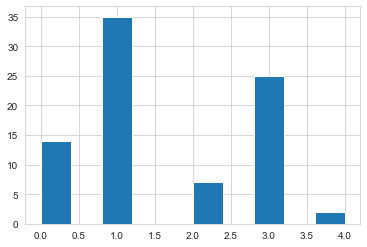

In [193]:
df_V3_melted_V4['Cluster'].hist()

df_V3_melted_V4['Cluster'].value_counts()

In [194]:
clustNum = df_V3_melted_V4[ df_V3_melted_V4['region']=='Saint Petersburg' ]['Cluster'].to_numpy()[0]

In [195]:
df_candidate_regions = df_V3_melted_V4[ df_V3_melted_V4['Cluster'] == clustNum ]
df_candidate_regions

region Sale Percentage             \
Type_Year                                       beer_2009  beer_2010   
7                      Chelyabinsk Oblast       79.947055  81.941309   
11                         Ivanovo Oblast       81.002425  79.925994   
16                         Kamchatka Krai       70.888469  71.253534   
19                        Khabarovsk Krai       78.785358  78.849145   
21                           Kirov Oblast       72.300469  73.087819   
22                          Komi Republic       73.641525  73.198381   
32                                 Moscow       69.304348  72.442244   
33                          Moscow Oblast       80.287310  79.841270   
39                            Omsk Oblast       89.220183  89.390519   
59                       Saint Petersburg       87.301587  83.665928   
67                      Sverdlovsk Oblast       78.653530  76.936027   
73                          Tyumen Oblast       78.727273  78.597122   
78                         Vologda Oblast       73.931997  78.591034   
80         Yamalo-Nenets Autonomous Okrug       78.727273  78.597122   

                                                                             \
Type_Year  beer_2011  beer_2012  beer_2013  beer_2014  beer_2015  beer_2016   
7          79.621381  78.216819  84.984026  79.381443  79.707495  77.737226   
11         79.364509  79.862306  80.589914  80.995475  82.118451  75.890411   
16         71.909385  72.380952  73.365385  75.173096  77.480916  79.813084   
19         79.638765  77.444795  79.780034  80.800000  76.741573  77.253669   
21         75.455214  76.145931  76.116303  77.930306  79.585153  79.190101   
22         74.798674  73.770492  73.684211  69.892473  71.888889  71.800680   
32         73.029842  73.208469  74.536664  72.783143  74.788335  74.408602   
33         81.512605  81.583199  81.885856  81.620718  81.739879  81.968569   
39         90.373799  89.942529  89.643168  87.678768  85.795455  84.044234   
59         80.765485  78.855975  71.521036  67.528271  65.996344  67.131474   
67         79.156989  80.496454  80.721831  80.021716  79.477612  75.923393   
73         79.183039  79.020333  79.448145  80.977131  81.573276  81.646274   
78         76.222756  80.206795  79.930495  73.556582  64.022140  64.756944   
80         80.331131  80.176565  81.146179  82.173499  83.451060  82.841530   

                       ... Total Sales                                \
Type_Year brandy_2009  ...  vodka_2016 wine_2009 wine_2010 wine_2011   
7            0.397088  ...        54.8     151.1     132.9    107.76   
11           0.404204  ...        73.0     123.7     108.1    111.41   
16           1.701323  ...       107.0     105.8     106.1    108.15   
19           0.748752  ...        95.4     120.2     128.6    131.77   
21           0.469484  ...        88.9     106.5     105.9    108.74   
22           0.648824  ...        88.3     123.3     123.5    126.66   
32           1.565217  ...        93.0     115.0     121.2    124.99   
33           1.117318  ...       120.9     125.3     126.0    133.28   
39           0.229358  ...        63.3     130.8     132.9    140.45   
59           0.793651  ...        50.2     163.8     135.3    102.68   
67           0.656814  ...        73.1     121.8     118.8    116.25   
73           1.181818  ...        89.9     110.0     111.2    109.43   
78           0.435920  ...        57.6     114.7     109.3    116.54   
80           1.181818  ...        91.5     110.0     111.2    125.63   

                                                            Cluster  
Type_Year wine_2012 wine_2013 wine_2014 wine_2015 wine_2016          
7              98.7      93.9      67.9      54.7      54.8       0  
11            116.2     105.1      88.4      87.8      73.0       0  
16            105.0     104.0     101.1     104.8     107.0       0  
19            126.8     118.2     112.5      89.0      95.4       0  
21            106.9      96.3      94.7     

# Thoughts

Using the K-mean algorithm, 15 regions were grouped into the same cluster that shared similar characteristics as Saint Petersburg. Now, we need to look at the total sales of alcohol and wine sales in 2016 to pick our top 10 region locations.

In [196]:
# Get the list of candidates
candidates = df_candidate_regions['region'].to_numpy()

df_V4 = df_V2[ df_V2['region'].isin(candidates) ]

df_V4

,year,region,wine,beer,vodka,champagne,brandy,Total Sales
11,1998,Vologda Oblast,8.158996,49.581590,40.376569,1.255230,0.627615,47.80
16,1998,Ivanovo Oblast,3.651539,53.990610,41.992697,0.260824,0.104330,38.34
23,1998,Kamchatka Krai,10.996564,43.814433,43.127148,1.374570,0.687285,58.20
27,1998,Kirov Oblast,7.220217,44.765343,46.209386,1.444043,0.361011,27.70
39,1998,Moscow,11.352254,50.083472,31.552588,5.843072,1.168614,59.90
...,...,...,...,...,...,...,...,...
1592,2016,Sverdlovsk Oblast,10.396717,75.923393,9.986320,2.325581,1.367989,73.10
1602,2016,Tyumen Oblast,5.672970,81.646274,9.343715,2.113459,1.223582,89.90
1605,2016,Khabarovsk Krai,7.337526,77.253669,11.740042,2.725367,0.943396,95.40
1608,2016,Chelyabinsk Oblast,9.671533,77.737226,9.306569,2.189781,1.094891,54.80


Text(0.5, 1.0, 'Mean Total Sales of 15 regions')

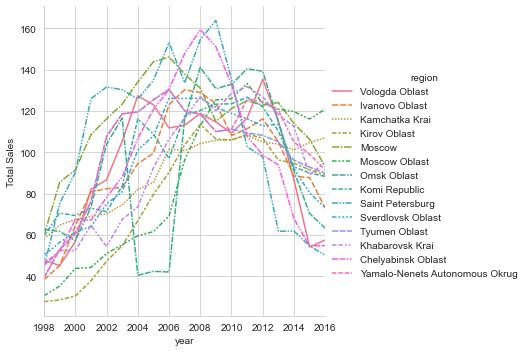

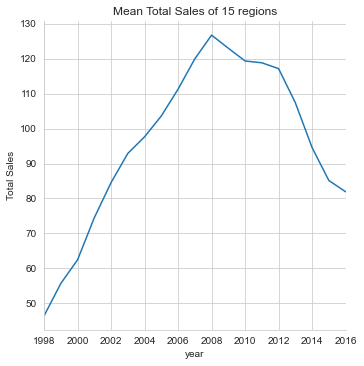

In [197]:
sns.relplot( x='year', y='Total Sales' , data=df_V4, kind = 'line', hue = 'region',style='region')
plt.xlim([1998,2016])
sns.relplot( x='year', y='Total Sales' , data=df_V4, kind = 'line',ci=None)
plt.xlim([1998,2016])
plt.title("Mean Total Sales of 15 regions")

(1998.0, 2016.0)

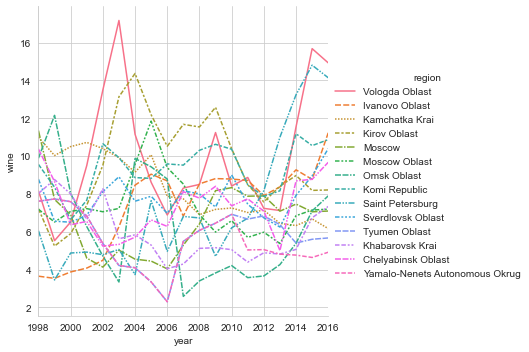

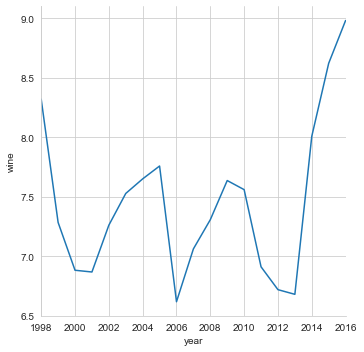

In [198]:
sns.relplot( x='year', y='wine' , data=df_V4, kind = 'line', hue = 'region',style='region')
plt.xlim([1998,2016])
sns.relplot( x='year', y='wine' , data=df_V4, kind = 'line',ci=None)
plt.xlim([1998,2016])

# Thoughts

By graphing, we can see that the 15 regions follow a similar pattern as Saint Petersburg. At this point, we need to determine which region has the highest correlation for wine sales . This will help us determine the 10 recommended locations.

In [209]:
df_V4_melted = pd.melt(df_V4,id_vars=['year','region'], value_vars = ['wine','beer','vodka','champagne','brandy'],var_name='Type',value_name='Sales')
df_V4_melted

,year,region,Type,Sales
0,1998,Vologda Oblast,wine,8.158996
1,1998,Ivanovo Oblast,wine,3.651539
2,1998,Kamchatka Krai,wine,10.996564
3,1998,Kirov Oblast,wine,7.220217
4,1998,Moscow,wine,11.352254
...,...,...,...,...
1325,2016,Sverdlovsk Oblast,brandy,1.367989
1326,2016,Tyumen Oblast,brandy,1.223582
1327,2016,Khabarovsk Krai,brandy,0.943396
1328,2016,Chelyabinsk Oblast,brandy,1.094891


In [210]:
df_V4_melted_wine = df_V4_melted[df_V4_melted['Type'] == 'wine']

rCorrelation = [ ]

for cand_regions in candidates:

    ROI = df_V4_melted_wine[ df_V4_melted_wine['region'] == cand_regions ]

    rCorrelation.append( LinearRegression( ROI['year'].to_numpy(), ROI['Sales'].to_numpy() ).rvalue ) 

df_region_rCorrelation = pd.DataFrame( {'Candidate':candidates,'rValue':rCorrelation})

df_region_rCorrelation.sort_values(by='rValue',ascending=False)

,Candidate,rValue
1,Ivanovo Oblast,0.858249
9,Saint Petersburg,0.807626
5,Komi Republic,0.415700
12,Vologda Oblast,0.289927
10,Sverdlovsk Oblast,0.287310
0,Chelyabinsk Oblast,0.196891
6,Moscow,0.140336
4,Kirov Oblast,0.084459
11,Tyumen Oblast,-0.113687
7,Moscow Oblast,-0.269501


# Thoughts

The following regions were selected based on sharing similar characteristics based on Saint Petersburg and having positive linear correlation on wine sales.

- Ivanovo Oblast
- Komi Republic
- Vologda Oblast
- Sverdlovsk Oblast
- Chelyabinsk Oblast
- Moscow
- Kirov Oblast
- Tymen Oblast
- Moscow Oblast
- Yamalo-Nenets Autonomous Okrug

